In [1]:
import boto3

bedrock_client = boto3.client('bedrock', region_name='us-east-1')

response = bedrock_client.list_foundation_models()

llm_dict = {}
for obj in  response['modelSummaries']:
    llm_dict[obj['modelName']] = obj['modelId']

In [2]:
def llm(modelid: str):

    from langchain_aws import ChatBedrockConverse

    return ChatBedrockConverse(model_id=modelid, region_name='us-east-1')

In [8]:
from langchain_core.prompts import ChatPromptTemplate 

from langgraph.prebuilt import create_react_agent

from langchain_mcp_adapters.client import MultiServerMCPClient

from dotenv import load_dotenv

import os

load_dotenv('/home/sagemaker-user/user-default-efs/CLONED_REPOS/LLM-World/.env')

client = MultiServerMCPClient(
    {
        "mcp_tools": {
            
            "url": os.getenv('MCP_URL'),
            "transport": "sse"
        }
    }
)

prompt = ChatPromptTemplate([
    ('system','You are a statistics agent.\n\n'
    'INSTRUCTIONS:\n'
    '- Assist ONLY with statistics-related tasks, DO NOT do any thing else\n'
    '- After you are done with your tasks, respond to the supervisor directly\n'
    '- Respond ONLY with the results of your work, do not include ANY other text.'),
    ('placeholder', '{messages}')  
])


mcp_tools = await client.get_tools()

statistics_agent = create_react_agent(llm(llm_dict['Claude 3.5 Sonnet']), tools=mcp_tools, prompt=prompt, name='statistics_agent')

In [9]:
from langchain_core.messages import convert_to_messages

def clean_print_msg(message, indent=False):
    clean_message = message.pretty_repr(html=True)
    if not indent:
        print(clean_message)
        return

    indented = '\n'.join('\t' + c for c in clean_message.split('\n'))
    print(indented)

def clean_print_msgs(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return
        
        graph_id = ns[-1].split(':')[0]
        print(f'Update from subgraph {graph_id}:')
        print('\n')
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f'Update from node {node_name}:'
        if is_subgraph:
            update_label = '\t' + update_label
        print(update_label)
        print('\n')

        messages = convert_to_messages(node_update['messages'])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            clean_print_msg(m, indent=is_subgraph)
        print('\n')

In [12]:
for tool in mcp_tools:
    print(tool.name)

greet
get_document_info
health_check
get_wiki_docs
get_latest_news
google_search_tool
get_pubmed_documents
get_arxiv_documents
scrape_url
get_public_company_news
add
subtract
multiply
divide
modulus
sq
sqrt
power
factorial
fibonacci
prime
palindrome
anagram
reverse
count_vowels
count_consonants
count_characters
count_words
count_sentences
count_paragraphs
count_lines
count_special_characters
count_digits
count_uppercase
count_lowercase
count_spaces
count_tabs
count_newlines
count_punctuation
count_whitespace
count_non_whitespace
count_alphanumeric
count_non_alphanumeric
count_uppercase_words
count_lowercase_words


In [55]:
import asyncio
query = 'Using google search provide an explination of What normality is'
query = 'What is 18 factorial?'

async for chunk in statistics_agent.astream({'messages':['user', query]}):
    clean_print_msgs(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: statistics_agent

[{'type': 'text', 'text': "To calculate the factorial of 18, I'll use the factorial function."}, {'type': 'tool_use', 'name': 'factorial', 'input': {'n': 18}, 'id': 'tooluse_ojRcBnl0TNWaB2VQXFbvJA'}]
Tool Calls:
  factorial (tooluse_ojRcBnl0TNWaB2VQXFbvJA)
 Call ID: tooluse_ojRcBnl0TNWaB2VQXFbvJA
  Args:
    n: 18


Update from node tools:


================================= Tool Message =================================
Name: factorial

6402373705728000


Update from node agent:


================================== Ai Message ==================================
Name: statistics_agent

18 factorial (18!) is 6402373705728000.




In [40]:
from langchain_core.tools import tool

import matplotlib.pyplot as plt

@tool
def gen_plot(plot_type: str = "line", title: str = "Plot", x: list = [1, 2, 3], y: list = [1, 4, 9]) -> str:
    """Generate a plot using Matplotlib. Returns base64-encoded PNG string.
    
    Args:
        plot_type: 'line', 'bar', or 'scatter'
        title: title of the plot
        x: list of x values
        y: list of y values
    """
    plt.figure()
    if plot_type == "line":
        plt.plot(x, y)
    elif plot_type == "bar":
        plt.bar(x, y)
    elif plot_type == "scatter":
        plt.scatter(x, y)
    else:
        return f"Unsupported plot_type: {plot_type}"

    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")

    buf = io.BytesIO()
    # plt.savefig(buf, format='png')
    # plt.close()
    buf.seek(0)
    img_bytes = buf.read()
    img_base64 = base64.b64encode(img_bytes).decode('utf-8')
    return img_base64

In [54]:
from langchain_core.prompts import ChatPromptTemplate 

from langgraph.prebuilt import create_react_agent

prompt = ChatPromptTemplate([
    ('system','You are a visualization agent.\n\n'
    'INSTRUCTIONS:\n'
    '- Assist ONLY with visualization-related tasks\n'
    '- After you are done with your tasks, respond to the supervisor directly\n'
    '- Respond ONLY with the results of your work, do not include ANY other text.'),
    ('placeholder', '{messages}')  
])

visualization_agent = create_react_agent(llm('us.'+llm_dict['Claude 3.7 Sonnet']), tools=[gen_plot], prompt=prompt, name='visualization_agent')

AttributeError: 'str' object has no attribute 'content'

Update from node agent:


================================== Ai Message ==================================
Name: visualization_agent

[{'type': 'text', 'text': "I'll generate a line plot with the specifications you provided."}, {'type': 'tool_use', 'name': 'gen_plot', 'input': {'plot_type': 'line', 'title': 'Sales Over Time', 'x': [1, 2, 3, 4, 5], 'y': [10, 20, 15, 30, 25]}, 'id': 'tooluse_yx7nK_JoRy6d9vnMNZ27cw'}]
Tool Calls:
  gen_plot (tooluse_yx7nK_JoRy6d9vnMNZ27cw)
 Call ID: tooluse_yx7nK_JoRy6d9vnMNZ27cw
  Args:
    plot_type: line
    title: Sales Over Time
    x: [1, 2, 3, 4, 5]
    y: [10, 20, 15, 30, 25]


Update from node tools:


================================= Tool Message =================================
Name: gen_plot

null


Update from node agent:


================================== Ai Message ==================================
Name: visualization_agent

[]




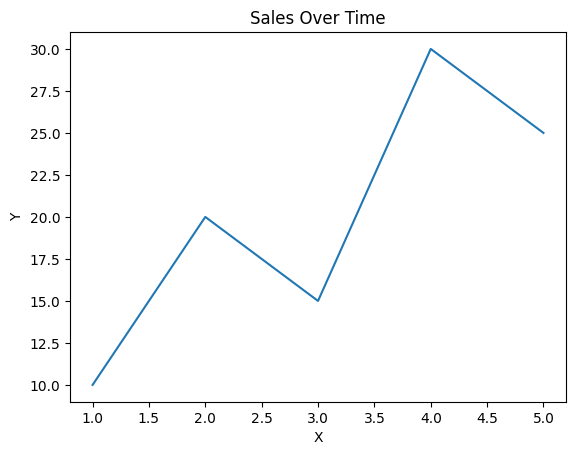

In [42]:
query = 'Generate a line plot with the title "Sales Over Time. The x-axis should be [1, 2, 3, 4, 5] representing months, and the y-axis should be [10, 20, 15, 30, 25] representing sales in thousands.'

for chunk in visualization_agent.stream({'messages':['user', query]}):
    clean_print_msgs(chunk)

In [48]:
from typing import Annotated

from langchain_core.tools import tool, InjectedToolCallId

from langgraph.prebuilt import InjectedState
from langgraph.graph import StateGraph, START, MessagesState
from langgraph.types import Command


def init_handoff_tool(*, agent_name: str, description: str | None=None):
    name = f'transfer_to_{agent_name}'
    description = description or f'Ask {agent_name} for help' 

    @tool(name, description=description)
    def handoff_tool(state: Annotated[MessagesState, InjectedState], tool_call_id: Annotated[str, InjectedToolCallId]) -> Command:
        tool_message = {
            'role':'tool',
            'content': f'Successfully transferred to {agent_name}',
            'name': name,
            'tool_call_id': tool_call_id}

        return Command(goto=agent_name, update={**state, 'messages':state['messages']+[tool_message]}, graph=Command.PARENT)
    return handoff_tool

    
assign_to_statistics_agent = init_handoff_tool(agent_name='statistics_agent', description='Assign task to a statistics agent.')
assign_to_visualization_agent = init_handoff_tool(agent_name='visualization_agent', description='Assign task to a visualization agent.')


In [56]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver


from langchain_aws import ChatBedrockConverse

from langchain_core.prompts import ChatPromptTemplate

llm = ChatBedrockConverse(model_id='us.'+llm_dict['Claude Sonnet 4'])

prompt = ChatPromptTemplate([
    ('system','You are a supervisor managing two agents\n\n'
    '- a research agent. Assign research-related tasks to this agent\n'
    '- a math agent. Assign math-related tasks to this agent\n'
    'Assign work to one agent at a time, do not call agents in parallel. \n'
    'Do not do any work yourself.'),
    ('placeholder', '{messages}')  
])

memory = MemorySaver()
config = {'configurable': {'thread_id': 'test_thread'}}

supervisor_agent = create_react_agent(model=llm, tools=[assign_to_visualization_agent, assign_to_statistics_agent], prompt=prompt, checkpointer=memory, name='supervisor')

In [57]:
from langgraph.graph import END

supervisor = (
    StateGraph(MessagesState)
    .add_node(supervisor_agent)
    .add_node(statistics_agent)
    .add_node(visualization_agent)
    .add_edge(START, 'supervisor')
    .add_edge('statistics_agent', 'supervisor')
    .add_edge('visualization_agent', 'supervisor')
    .compile()
)

In [58]:
### Dataset 
from sklearn.datasets import load_wine
import numpy as np
import pandas as pd

data = load_wine()
# print(data.keys())

lbl = data['target_names']
header = [a+str(n) for n,a in enumerate(np.repeat('A',data['data'].shape[1]))]
df = pd.DataFrame(data['data'], columns=header)
df = df.iloc[:20,:]


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_statistics_agent

Successfully transferred to statistics_agent


Update from node statistics_agent:


================================== Ai Message ==================================
Name: statistics_agent

I apologize for the error. It seems that the mathematical tools are not available for direct calculation. In this case, I'll calculate the mean manually.

The mean is calculated by summing all the numbers and dividing by the count of numbers.

Sum: 10 + 20 + 15 + 30 + 25 = 100
Count: 5
Mean: 100 / 5 = 20

The mean of [10, 20, 15, 30, 25] is 20.

Unfortunately, I don't have access to a tool for creating plots directly. To provide a visual representation, we would need additional graphing capabilities.


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_visualization_agent

Succ

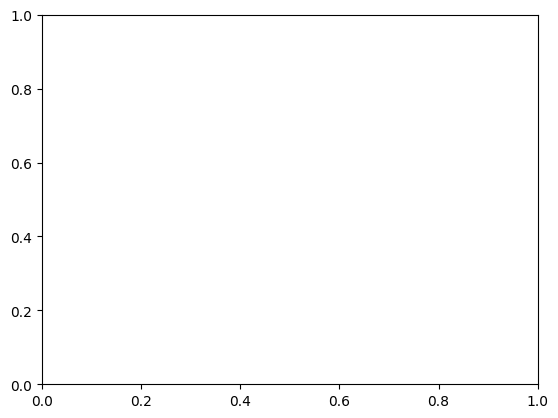

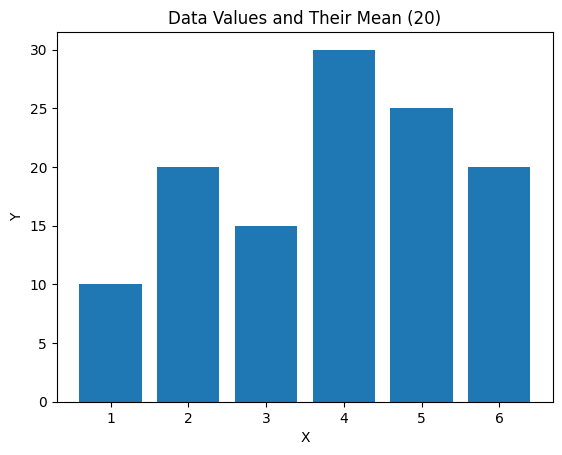

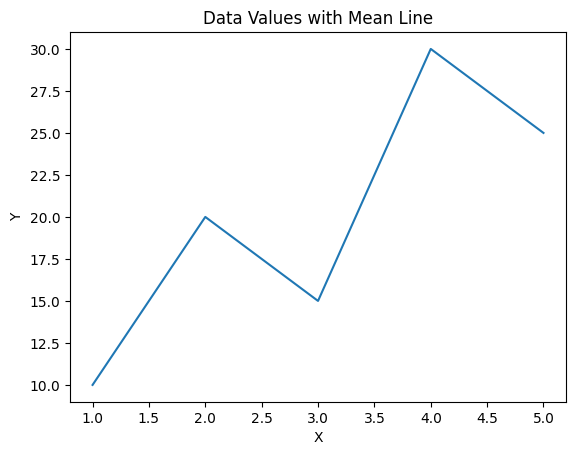

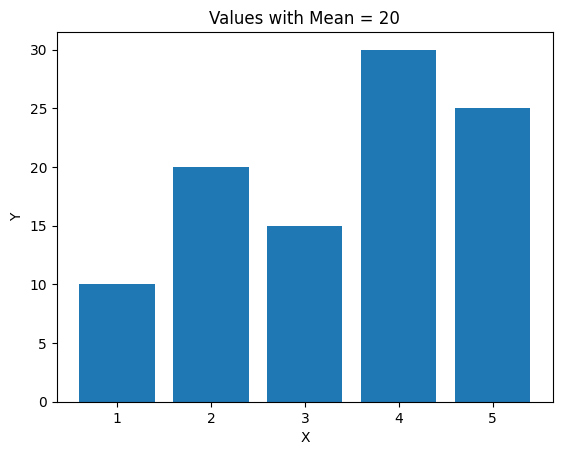

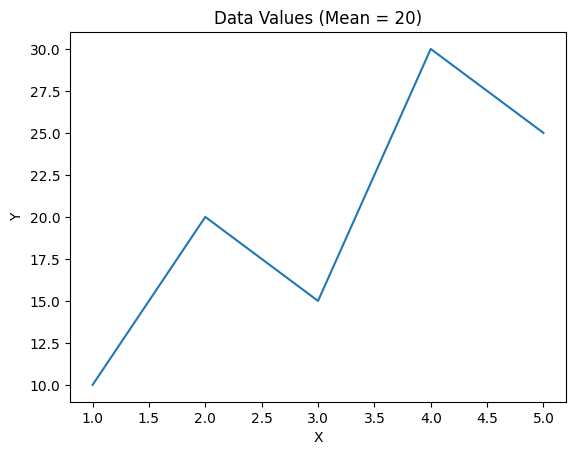

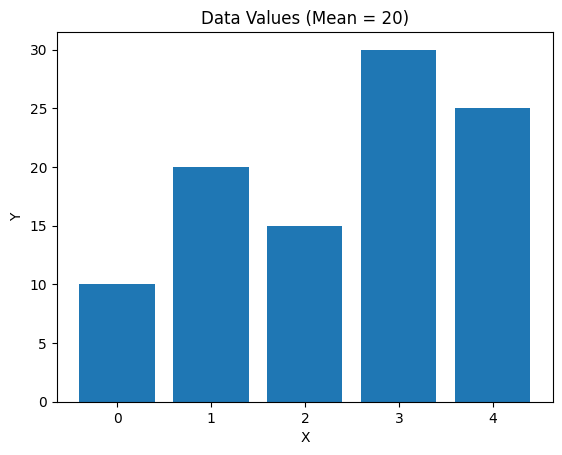

In [59]:
query = 'using google and the tools you have access to, calculate the mean of [10, 20, 15, 30, 25] and provide a single plot of the result'


for chunk in supervisor.stream({'messages':[{'role':'user','content': [{'type': 'text', 'text':query}]}]}):
    clean_print_msgs(chunk, last_message=True)